# Comparing Speech-to-Text algorithms (Rev AI vs. GCP)

## 0. Convert video into audio

#### Clip 1

In [2]:
video_path = '/home/dylan/Git/automatic-subtitle-generator/inputs/RAW-long.m4v'
audio_path = '/home/dylan/Jupyter/Auto-Sub-Gen/RAW-long.wav'

#### Clip 2

In [56]:
video_path = '/home/dylan/Git/automatic-subtitle-generator/inputs/streetfood.m4v'
audio_path = '/home/dylan/Jupyter/Auto-Sub-Gen/streetfood.wav'

In [4]:
import subprocess
command = f'ffmpeg -i {video_path} -ab 160k -ac 1 -ar 44100 -vn {audio_path}'
subprocess.call(command, shell=True)

0

## 1. Use `NoiseReduce` to remove ambient noise?

In [7]:
import noisereduce as nr
import scipy.io.wavfile as wavfile
import numpy as np
# load data
rate, data = wavfile.read(f'{audio_path}')
shape = data.shape  # numpy shape of the original audio data

# select section of data that is noise
noisy_part = data[int(rate*25.8):int(rate*27.6)]
ambient_path = f'{temp_dir}/ambient.wav'
wavfile.write(ambient_path, rate, noisy_part)

/Users/dylanklein/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


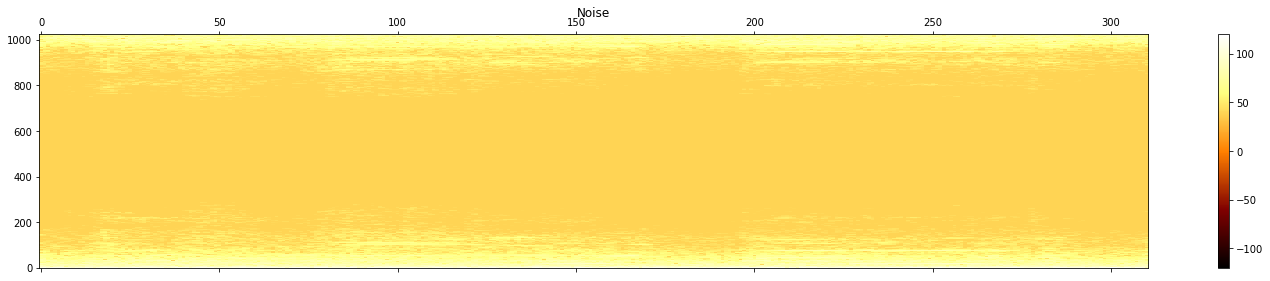

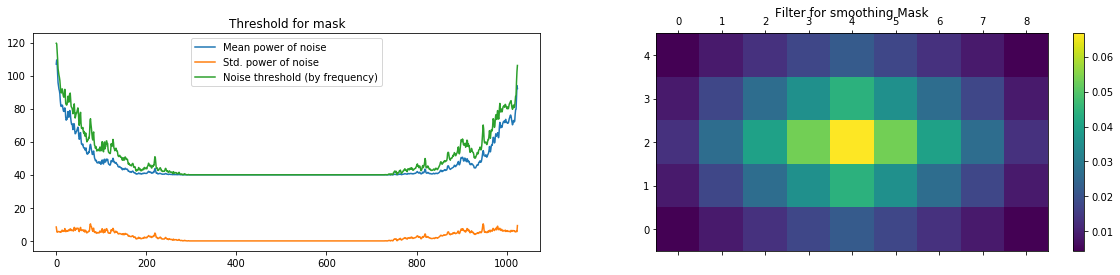

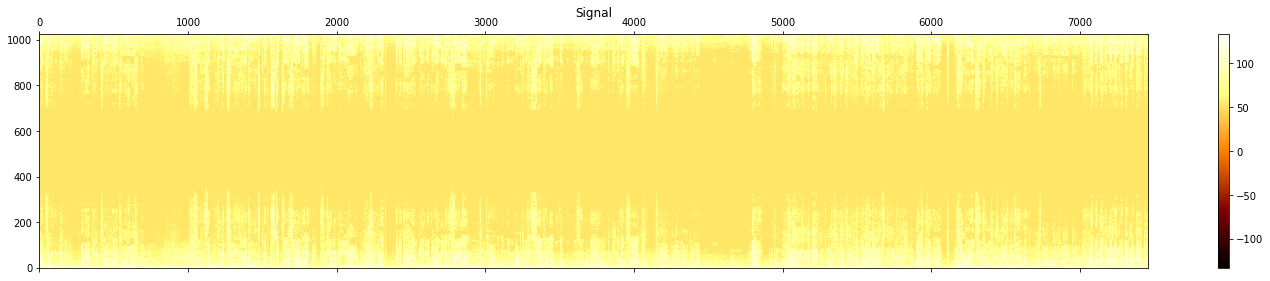

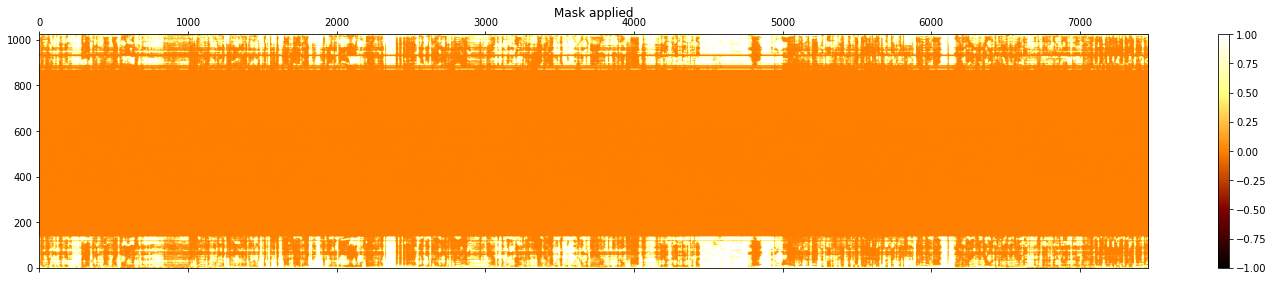

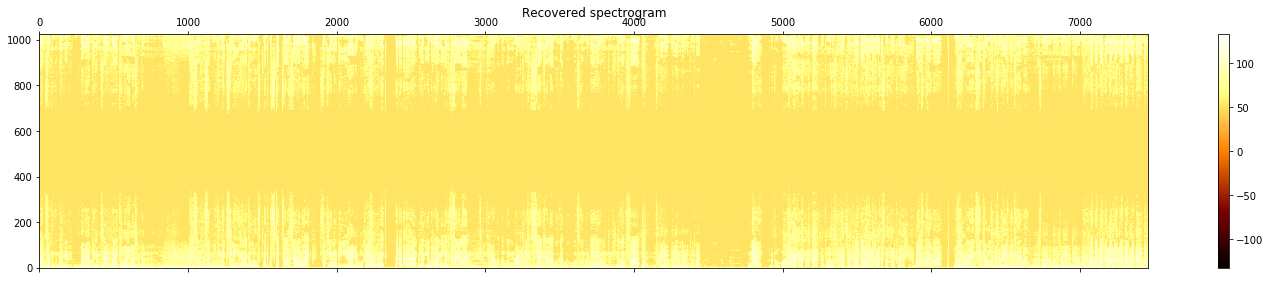

In [10]:
# format/shape audio clips
data = data.astype(np.float32)
data = data.flatten()
noisy_part = noisy_part.astype(np.float32)
noisy_part = noisy_part.flatten()

# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=True)

# reshape/reformat audio clip
reduced_noise = reduced_noise.reshape(shape)
reduced_noise = reduced_noise.astype(np.int16)
filtered_path = f'{temp_dir}/filtered.wav'
wavfile.write(filtered_path, rate, reduced_noise)

## 2. Use `Rev.AI` package to do Speech-to-Text conversion
Install the package using:
`pip install --upgrade rev_ai`

In [57]:
token = "02RGq5arUk0B7TJ6pbJCYqrWaOXg8uyBa_4eOqm6AoXuCzY-l11ji6iL7SUxqgiSvPpKYMHgjQpExOYQgI7J0Usqo5pgw"
file_path = "streetfood.wav"

In [58]:
from rev_ai import apiclient

# create your client
client = apiclient.RevAiAPIClient(token)

In [61]:
# you can send a local file
job = client.submit_job_local_file(file_path, skip_punctuation=True)
job

In [62]:
job_details = client.get_job_details(job.id)
job_details

In [63]:
transcript_text = client.get_transcript_text(job.id)
transcript_text

"Speaker 0    00:00    Nah man I think every man for himself like if you're delivering the food he should be able to eat a tiny bit of the three and that's fine it's a tax that the government takes out of your income you take as a driver as somebody as you don't like chump and butts out of my burger I don't mind it's like just taking the lettuce out of your burger I like just taking tomato out of your bag so those are still systematically taking a whole thing out of the burger yeah but you probably won't notice well that's true and I don't think I'd mind if they're taking the whole thing they're handling your food people have handled it making it sound as clean as we'd like to pretend they are very accepting of all not everybody would be as progressive and accepting I work in a very intense hospitality environment yeah just sit down behind a counter and you're like you for as much food as he can like right food is not so much like a goal may experiences it is a way to survive and sorry

In [64]:
transcript_text = client.get_transcript_json(job.id)
transcript_text

{'monologues': [{'speaker': 0,
   'elements': [{'type': 'text',
     'value': 'Nah',
     'ts': 0.06,
     'end_ts': 0.24,
     'confidence': 0.77},
    {'type': 'text',
     'value': 'man',
     'ts': 0.24,
     'end_ts': 0.48,
     'confidence': 0.89},
    {'type': 'text',
     'value': 'I',
     'ts': 0.54,
     'end_ts': 0.66,
     'confidence': 1.0},
    {'type': 'text',
     'value': 'think',
     'ts': 0.66,
     'end_ts': 0.87,
     'confidence': 1.0},
    {'type': 'text',
     'value': 'every',
     'ts': 0.87,
     'end_ts': 1.08,
     'confidence': 1.0},
    {'type': 'text',
     'value': 'man',
     'ts': 1.08,
     'end_ts': 1.32,
     'confidence': 1.0},
    {'type': 'text',
     'value': 'for',
     'ts': 1.32,
     'end_ts': 1.41,
     'confidence': 1.0},
    {'type': 'text',
     'value': 'himself',
     'ts': 1.41,
     'end_ts': 1.74,
     'confidence': 0.99},
    {'type': 'text',
     'value': 'like',
     'ts': 1.77,
     'end_ts': 1.89,
     'confidence': 0.78},
 

## 3. Google comparison

In [10]:
%env GOOGLE_APPLICATION_CREDENTIALS=/home/dylan/Git/automatic-subtitle-generator/creds/google_creds.json
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]

env: GOOGLE_APPLICATION_CREDENTIALS=/home/dylan/Git/automatic-subtitle-generator/creds/google_creds.json


'/home/dylan/Git/automatic-subtitle-generator/creds/google_creds.json'

In [65]:
from google.cloud import speech_v1p1beta1
import io

def sample_long_running_recognize(local_file_path, num_speakers=2):
    """
    Print confidence level for individual words in a transcription of a short audio
    file
    Separating different speakers in an audio file recording

    Args:
      local_file_path Path to local audio file, e.g. /path/audio.wav
    """

    client = speech_v1p1beta1.SpeechClient()

    # local_file_path = 'resources/commercial_mono.wav'

    # If enabled, each word in the first alternative of each result will be
    # tagged with a speaker tag to identify the speaker.
    enable_speaker_diarization = True

    # Optional. Specifies the estimated number of speakers in the conversation.
    diarization_speaker_count = num_speakers

    # When enabled, the first result returned by the API will include a list
    # of words and the start and end time offsets (timestamps) for those words.
    enable_word_time_offsets = True
    
    # The language of the supplied audio
    language_code = "en-US"  # Currently, "video" model is only available on en-US.
    
    config = {
        "enable_speaker_diarization": enable_speaker_diarization,
        "diarization_speaker_count": diarization_speaker_count,
        "language_code": language_code,
        "model": "video",
        "enable_word_time_offsets": enable_word_time_offsets
    }
    
    with io.open(local_file_path, "rb") as f:
        content = f.read()
    audio = {"content": content}

    operation = client.long_running_recognize(config, audio)

    print(u"Waiting for operation to complete...")
    response = operation.result()
    
    return response

In [65]:
from google.cloud import speech_v1p1beta1
import io

def sample_long_running_recognize(storage_uri, num_speakers=2):
    """
    Print confidence level for individual words in a transcription of a short audio
    file
    Separating different speakers in an audio file recording

    Args:
      storage_uri URI for audio file in Cloud Storage, e.g. gs://[BUCKET]/[FILE]
    """

    client = speech_v1p1beta1.SpeechClient()

    # If enabled, each word in the first alternative of each result will be
    # tagged with a speaker tag to identify the speaker.
    enable_speaker_diarization = True

    # Optional. Specifies the estimated number of speakers in the conversation.
    diarization_speaker_count = num_speakers

    # When enabled, the first result returned by the API will include a list
    # of words and the start and end time offsets (timestamps) for those words.
    enable_word_time_offsets = True
    
    # The language of the supplied audio
    language_code = "en-US"  # Currently, "video" model is only available on en-US.
    
    config = {
        "enable_speaker_diarization": enable_speaker_diarization,
        "diarization_speaker_count": diarization_speaker_count,
        "language_code": language_code,
        "model": "video",
        "enable_word_time_offsets": enable_word_time_offsets
    }
    
    audio = {"uri": storage_uri}

    operation = client.long_running_recognize(config, audio)

    print(u"Waiting for operation to complete...")
    response = operation.result()
    
    return response

In [6]:
# Converting stereo audio to mono
import subprocess
mono_path = f'/home/dylan/Jupyter/Auto-Sub-Gen/streetfood_mono.wav'
command = f'ffmpeg -i {audio_path} -ac 1 {mono_path}'
subprocess.call(command, shell=True)

0

In [80]:
gcp_uri = "gs://sample-audio-clips/audio/streetfood-long-mono.wav"

In [82]:
response = sample_long_running_recognize(gcp_uri, num_speakers=2)

Waiting for operation to complete...


### Analyse the response from Google Speech Cloud

In [83]:
import pandas as pd

def analyse_result(response):
    '''
    This function analyses the response from the Google Speech Cloud model. A pandas dataframe is outputted.
    '''    
    for result in response.results:
        # First alternative has words tagged with speakers
        alternative = result.alternatives[0]
        # print(u"Transcript: {}".format(alternative.transcript))
        
        # Capture data in pandas data frame
        d = []
        for w in alternative.words:
            d.append(
                {"Start (secs)": w.start_time.seconds,
                 "Start (ns)": w.start_time.nanos,
                 "End (secs)": w.end_time.seconds,
                 "End (ns)": w.end_time.nanos,
                 "Word": w.word,
                 "Speaker": w.speaker_tag})
            
        df = pd.DataFrame(d)  # Saves the last dataframe in response.results, is this desirable?
    return df

In [84]:
words_df = analyse_result(response)

### Manipulate dataframe to save phrases instead of individual words
This should be based on the following criteria. A new phrase begins if:
1. There is a change of speaker, or
2. Max # of words are reached in a phrase, or
3. There is a gap/pause in between words.

In [70]:
def create_captions(df_in, word_limit=7):
    '''
    This function takes a dataframe of individual words as input and applies logic
    to output a new dataframe. However instead of individual words per row,
    there will now be entire captions per row of the new pandas dataframe.
    The phrases are differentiated based on speaker identities, any pauses in the audio,
    as well as a word limit per caption. Default word_limit per caption is 7.
    '''
    columns = ["Start (secs)",
               "End (secs)",
               "Duration (secs)",
               "Captions",
               "Speaker"]
    df_out = pd.DataFrame(columns=columns)  # Create a new dataframe
    row = 0  # Row counter
    consecutive = 0  # To track how many consecutive words in a caption
    
    for idx in range(len(df_in)):
        start_s = df_in.iloc[idx,0]  # Find the current timestamp
        start_ns = df_in.iloc[idx,1]  # Find the current timestamp
        start = start_s + start_ns / 1e9  # Combine into 1 time value
        
        end_s = df_in.iloc[idx,2]  # Find the current timestamp
        end_ns = df_in.iloc[idx,3]  # Find the current timestamp
        end = end_s + end_ns / 1e9  # Combine into 1 time value
        
        prev_end_s = df_in.iloc[idx-1,2]  # Find the previous end timestamp
        prev_end_ns = df_in.iloc[idx-1,3]  # Find the previous end timestamp
        prev_end = prev_end_s + prev_end_ns / 1e9  # Combine into 1 time value
        
        word = df_in.iloc[idx,4]  # Find the current word
        tag = df_in.iloc[idx,5]  # Find the current speaker tag
        prev_tag = df_in.iloc[idx-1,5]  # Find the previous speaker tag
        
        # Set three conditions for grouping words into captions
        # 1) Compare speaker tag with previous speaker tag
        if tag == prev_tag: same_speaker = True
        else: same_speaker = False
        # 2) Check that consecutive counter is under word limit
        if consecutive < word_limit - 1: under_limit = True
        else: under_limit = False
        # 3) Check for pauses in the audio
        if start == prev_end: no_pause = True
        else: no_pause = False
        
        # If any of the above three conditions are False, create a new row.
        if same_speaker and under_limit and no_pause:
            consecutive += 1  # Increment the consecutive counter
            df_out.at[row, "Captions"] = df_out.at[row, "Captions"] + " "  # Add a space
            df_out.at[row, "Captions"] = df_out.at[row, "Captions"] + word  # Add the new word to the caption
            df_out.at[row, "End (secs)"] = end
            df_out.at[row, "Speaker"] = tag
        else: 
            consecutive = 0  # Reset the consecutive counter
            row += 1  # Move to a new row
            df_out.at[row, "Captions"] = word  # Add the new word to the next caption
            df_out.at[row, "Start (secs)"] = start
            df_out.at[row, "End (secs)"] = end
            df_out.at[row, "Speaker"] = tag
        
    # Calculate caption durations
    df_out["Duration (secs)"] = df_out["End (secs)"].subtract(df_out["Start (secs)"])

    return(df_out)

In [85]:
captions = create_captions(words_df, 4)

In [86]:
captions

,Start (secs),End (secs),Duration (secs),Captions,Speaker
1,0,1.1,1.1,dominate I think every,1
2,1.1,1.9,0.8,man for himself like,1
3,1.9,2.7,0.8,if you ordering the,1
4,2.7,3.4,0.7,food you should be,1
5,3.4,4.1,0.7,able to eat tiny,1
...,...,...,...,...,...
67,79.1,79.6,0.5,clothing,1
68,79.8,80.7,0.9,and even though this,1
69,80.7,81.3,0.6,and you go to,1
70,81.3,82.3,1,buy the street food,1


In [87]:
len(captions)

71

## 4. Save results to .csv file

In [88]:
def save_csv(df, filename):
    '''
    This function saves a dataframe to disk as a .csv file.
    '''
    df[df["Speaker"] > 0].to_csv(f'{filename}', mode='a', header=True)  # Only save where speaker tag has a non-zero value

In [89]:
save_csv(captions, 'new_csv2.csv')